# import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np 
import scipy
from scipy.stats import kstest, false_discovery_control

plt.rcParams.update({'font.size': 24})

# Clinvar analysis output
data = pd.read_csv('../data/allClinvarMissense.csv',header=0,index_col=0)

# cleanup

### Disease significance

In [2]:
data['class']='none'
data['disease_associated']='NO'
data.loc[~data['disease'].str.contains('not'),'disease_associated']='YES'
data['significance']=data['signi']
data.loc[data['signi'].str.contains('Benign|benign'),'significance']='Likely_benign'
data.loc[data['signi'].str.contains('Conflicting'),'significance']='Unknown_significance'
data.loc[data['signi'].str.contains(r'uncertain',case=False),'significance']='Unknown_significance'
data.loc[data['signi'].str.contains(r'pathogenic|risk',case=False),'significance']='Likely_pathogenic'
data.loc[data['signi'].str.contains(r'other|protective|drug|not_provided|Affects|sensitivity|unflagged|association',case=False),'significance']='Not_provided'

### Mutation type and disorder

In [3]:
data['more_pos']='NO'
data['more_neg']='NO'
data.loc[data['changeType'].str.contains('neg>|>pos'),'more_pos']='YES'
data.loc[data['changeType'].str.contains('>neg|pos>'),'more_neg']='YES'
data['resDisordered']='ND'
data.loc[data['res_disorder']>0.7,'resDisordered']='YES'
data.loc[data['res_disorder']<0.3,'resDisordered']='NO'

### Mutation review status

In [4]:
data['rev_star']=0
data.loc[data['revstat'].str.contains('single_submitter|conflicting_classifications'),'rev_star']=1
data.loc[data['revstat'].str.contains('multiple_submitters'),'rev_star']=2
data.loc[data['revstat'].str.contains('expert_panel'),'rev_star']=3
data.loc[data['revstat'].str.contains('guideline'),'rev_star']=3
# filter out all 0-star clinvar entires
data=data[data['rev_star']>0]

### FDR-adjusted p-values

In [5]:
pval_cols = data.columns[data.columns.str.contains('pval')]
data[pval_cols]=data[pval_cols].fillna(1)
for i in pval_cols:
    data[i+'_adj'] = -np.log10(scipy.stats.false_discovery_control(np.power(10,-data[i])))


# mutation counts

In [6]:
N_all_prots = data[['upID','N_res','N_disordered']].drop_duplicates().shape[0]
N_all = data.shape[0]
N_all_diseaseAssociated = data[data['disease_associated']=='YES'].shape[0]
N_all_unknownSig = data[data['significance']=='Unknown_significance'].shape[0]
N_IDR = data[data['resDisordered']=='YES'].shape[0]
N_IDR_diseaseAssociated = data[(data['resDisordered']=='YES')&(data['disease_associated']=='YES')].shape[0]
N_IDR_unknownSig = data[(data['resDisordered']=='YES')&(data['significance']=='Unknown_significance')].shape[0]
N_expand = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_logFC_30']>0)&(data['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
N_compact = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_logFC_30']<0)&(data['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
N_nochange = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_30_adj']<1.3)].shape[0]
N_Re_change = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
N_Re_change_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_30_adj']>1.3)]['upID'].unique().shape[0]
print('total proteins in dataset: %i' % N_all_prots)
print('total variants in IDRs / all / ratio: %i / %i / %.2f' % (N_IDR,N_all,N_IDR/N_all))
print('ratio of disease associated variants in IDRs / all: %.2f / %.2f'%
      (N_IDR_diseaseAssociated/N_IDR,N_all_diseaseAssociated/N_all))
print('ratio of VUSs in IDRs / all: %.3f / %.3f' % 
      (N_IDR_unknownSig/N_IDR,N_all_unknownSig/N_all))
print('total variants that expand/compact/do nothing in IDRs: %i / %i / %i' % 
      (N_expand,N_compact,N_nochange))
print('total number of variants that change ensemble: %i in %i proteins'%(N_Re_change,N_Re_change_prots))

total proteins in dataset: 19968
total variants in IDRs / all / ratio: 274448 / 955146 / 0.29
ratio of disease associated variants in IDRs / all: 0.25 / 0.29
ratio of VUSs in IDRs / all: 0.847 / 0.858
total variants that expand/compact/do nothing in IDRs: 101783 / 117179 / 55486
total number of variants that change ensemble: 218962 in 14157 proteins


# histograms of variant Re of different tile lengths

dashed histograms are mutants, solid are wildtype tiles. Data shows a broadening of distribution as tile length increases.

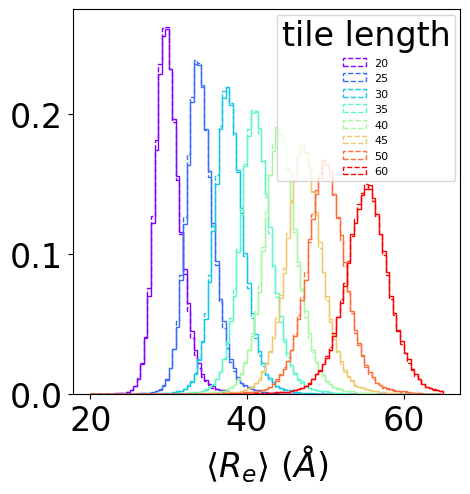

In [7]:
fig,ax = plt.subplots(figsize=[5,5])
bins = np.linspace(20,65,100)
colors=plt.cm.rainbow(np.linspace(0,1,8))
for i,window in enumerate(['20','25','30','35','40','45','50','60']):
    _=ax.hist(data.loc[(data['resDisordered']=='YES'),'mut_Re_avg_'+window],linestyle='--',density=True,bins=bins,histtype='step',color=colors[i],label=window)
    _=ax.hist(data.loc[(data['resDisordered']=='YES'),'wt_Re_avg_'+window],density=True,bins=bins,histtype='step',color=colors[i])
_=ax.legend(title='tile length',fontsize=8)
_=ax.set_xlabel(r'$\langle R_e \rangle \ (\AA)$')

## $\Delta R_e$ Volcano plots for different tile lengths

20-res tiles: no change: 86385 (0.32), compacting: 97624 (0.36), expanding: 86447 (0.32)
25-res tiles: no change: 74029 (0.27), compacting: 105953 (0.39), expanding: 91992 (0.34)
30-res tiles: no change: 66610 (0.24), compacting: 110810 (0.41), expanding: 95123 (0.35)
35-res tiles: no change: 61756 (0.23), compacting: 113884 (0.42), expanding: 97294 (0.36)
40-res tiles: no change: 58341 (0.21), compacting: 116004 (0.42), expanding: 98786 (0.36)
45-res tiles: no change: 55943 (0.20), compacting: 117479 (0.43), expanding: 99911 (0.37)
50-res tiles: no change: 53940 (0.20), compacting: 118767 (0.43), expanding: 100778 (0.37)
60-res tiles: no change: 51219 (0.19), compacting: 120302 (0.44), expanding: 102039 (0.37)


(-3.0, 3.0)

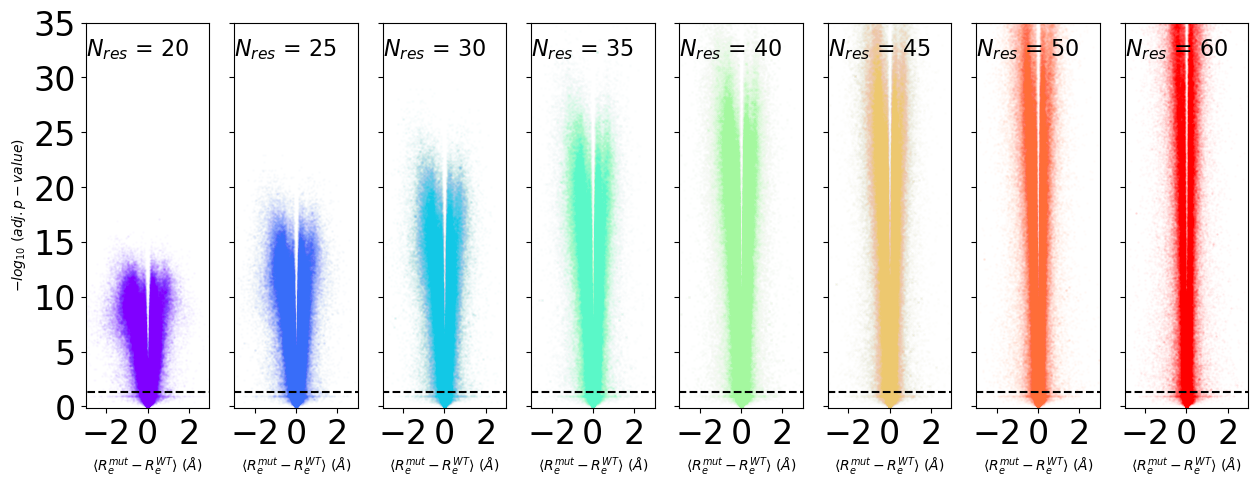

In [8]:
fig,ax=plt.subplots(1,8,figsize=[15,5],sharex=True,sharey=True)
p_val_max=-np.log10(0.01)
colors=plt.cm.rainbow(np.linspace(0,1,8))
plt.rcParams.update({'font.size': 5})
delta_min = 0

for i,window in enumerate(['20','25','30','35','40','45','50','60']):
    sliced=data[(data['resDisordered']=='YES')&(data['rev_star']>0)]
    N_expand = sliced[(sliced['mut_vs_wt_Re_delta_'+window]>delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
    N_compact = sliced[(sliced['mut_vs_wt_Re_delta_'+window]<-delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
    N_nochange = sliced[(sliced['mut_vs_wt_Re_pval_'+window]<p_val_max)].shape[0]
    N_tot = N_expand+N_compact+N_nochange
    print('%s-res tiles: no change: %i (%.2f), compacting: %i (%.2f), expanding: %i (%.2f)'%
          (window, N_nochange,N_nochange/N_tot,N_compact,N_compact/N_tot,N_expand,N_expand/N_tot))
    ax[i].scatter(sliced['mut_vs_wt_Re_delta_'+window],sliced['mut_vs_wt_Re_pval_'+window+'_adj'],
                s=1.,alpha=0.01,color=colors[i])
    ax[i].plot([-10,10],[1.3,1.3],'--',c='k')
    ax[i].text(-3,32,'$N_{res}$ = '+ window,fontsize=16)
    ax[i].set_xlabel(r'$\langle R_{e}^{mut}-R_{e}^{WT} \rangle \ (\AA)$',fontsize=10)
ax[0].set_ylabel(r'$-log_{10}\ (adj. p-value)$',fontsize=10)
ax[0].set_ylim(-0.1,35)
ax[0].set_xlim(-3,3)

## $\Delta R_e$ histogram for significant hits only (adj. p-value < 0.01)

Despite tile lengths increasing, the overall magnitude of the mutation effect on $\Delta R_e$ stays the same (x- and y-axis are linked in all panels)

Text(0.5, 0, '$\\langle R_{e}^{mut}-R_{e}^{WT} \\rangle \\ (\\AA)$')

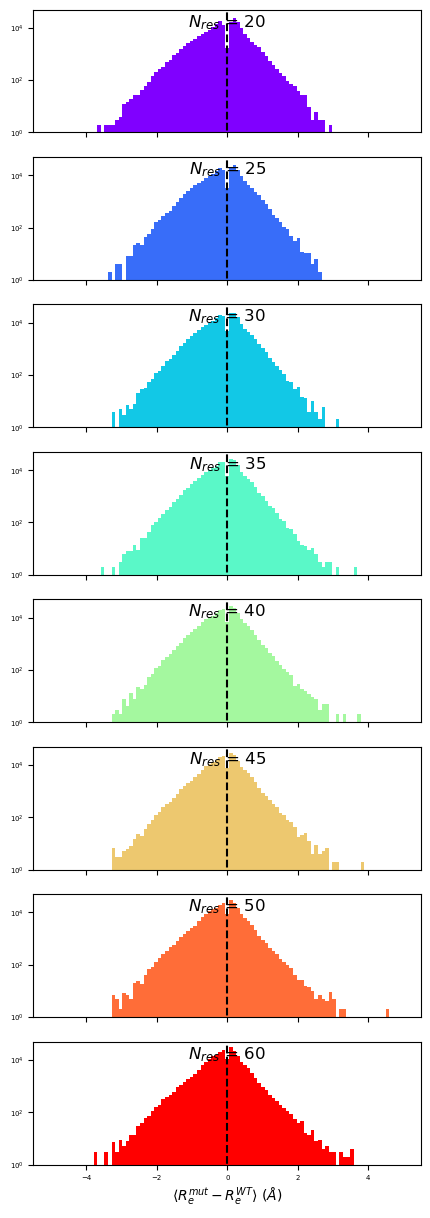

In [9]:
fig,ax=plt.subplots(8,1,figsize=[5,15],sharex=True,sharey=True)
p_val_max=-np.log10(0.01)
colors=plt.cm.rainbow(np.linspace(0,1,8))
plt.rcParams.update({'font.size': 10})
delta_min = 0
bins=np.linspace(-5,5,100)
for i,window in enumerate(['20','25','30','35','40','45','50','60']):
    sliced=data[(data['resDisordered']=='YES')&(data['rev_star']>0)&(data['mut_vs_wt_Re_pval_'+window]>p_val_max)]
    ax[i].hist(sliced['mut_vs_wt_Re_delta_'+window],bins=bins,color=colors[i],log=True)
    ax[i].text(0,39000,'$N_{res}$ = '+ window,va='top',ha='center',fontsize=12)
    ax[i].plot([0,0],[0.00001,100000],'--',c='k')
    ax[i].set_ylim(1,50000)
ax[-1].set_xlabel(r'$\langle R_{e}^{mut}-R_{e}^{WT} \rangle \ (\AA)$',fontsize=10)

## Volcano for Fig. 2B

C:\Users\ssukenik\AppData\Local\Temp\ipykernel_11632\2861353907.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced['color']='grey'


total: 274448, no change: 51716 (0.188), compacting: 119589 (0.436), expanding: 103143 (0.376)
from a total of 15078 proteins


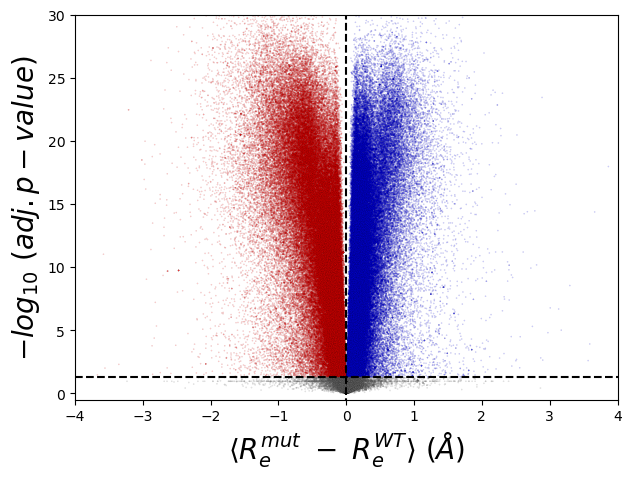

In [10]:
fig,ax=plt.subplots(figsize=[7,5])
window='35'
p_val_max=-np.log10(0.01)
delta_min = 0
plt.rcParams.update({'font.size': 18})

# slice and set color
sliced=data[(data['resDisordered']=='YES')&(data['rev_star']>0)]
sliced['color']='grey'
sliced.loc[(sliced['mut_vs_wt_Re_delta_'+window]>delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max),'color']='b'
sliced.loc[(sliced['mut_vs_wt_Re_delta_'+window]<-delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max),'color']='r'

# print out counts
N_expand = sliced[(sliced['mut_vs_wt_Re_delta_'+window]>delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
N_compact = sliced[(sliced['mut_vs_wt_Re_delta_'+window]<-delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
N_nochange = sliced[(sliced['mut_vs_wt_Re_pval_'+window+'_adj']<p_val_max)].shape[0]
N_proteins = len(sliced['upID'].unique())
print('total: %i, no change: %i (%.3f), compacting: %i (%.3f), expanding: %i (%.3f)'%
      (len(sliced),N_nochange,N_nochange/len(sliced),N_compact,N_compact/len(sliced),N_expand,N_expand/len(sliced)))
print('from a total of %i proteins'%N_proteins)

# plot volcano
ax.scatter(sliced['mut_vs_wt_Re_delta_'+window],sliced['mut_vs_wt_Re_pval_'+window+'_adj'],
                s=1,alpha=0.2,color=sliced['color'],edgecolor='k',linewidth=0.1)
ax.plot([-4,4],[p_val_max,p_val_max],'--',c='k')
ax.plot([0,0],[-1,40],'--',c='k')
ax.set_xlim(-4,4)
ax.set_ylim(-0.5,30)
ax.set_xticks(np.arange(-4,5,1))
ax.set_xlabel(r'$\langle R_e^{mut}\ -\  R_e^{WT} \rangle \ (\AA)$',fontsize=20)
ax.set_ylabel(r'$-log_{10}\ (adj. p-value)$',fontsize=20)
plt.savefig('volcano.png')


## $\Delta R_e$ histogram for Fig. 2B

C:\Users\ssukenik\AppData\Local\Temp\ipykernel_11632\3160795610.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,lw=0.2)


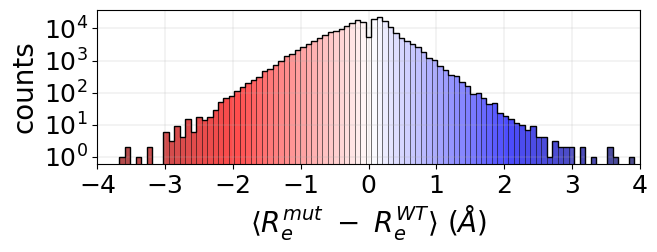

In [11]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(figsize=[7,2])
bins=np.linspace(-4,4,100)
scale=np.linspace(0,1,100)
sliced=data[(data['resDisordered']=='YES')&(data['rev_star']>0)&(data['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)]
n,bins,patches = ax.hist(sliced['mut_vs_wt_Re_delta_'+window],bins=bins,log=True)
ax.hist(sliced['mut_vs_wt_Re_delta_'+window],bins=bins,log=True,histtype='step',color='k')
# Color the bars based on x-position
for i, patch in enumerate(patches):
    color = plt.cm.seismic_r(scale[i])  # Use a colormap to map x-position to color
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('k')
    patch.set_linewidth(0.4)
ax.grid(b=True,lw=0.2)
ax.set_yticks([1,10,100,1000,10000])
ax.set_xticks(np.arange(-4,5,1))
ax.set_xlim(-4,4)
ax.set_xlabel(r'$\langle R_e^{mut}\ -\  R_e^{WT} \rangle \ (\AA)$',fontsize=20)
ax.set_ylabel('counts',fontsize=20)
fig.savefig('dRe_hist.svg')

## Mutations by type for Fig. 2C

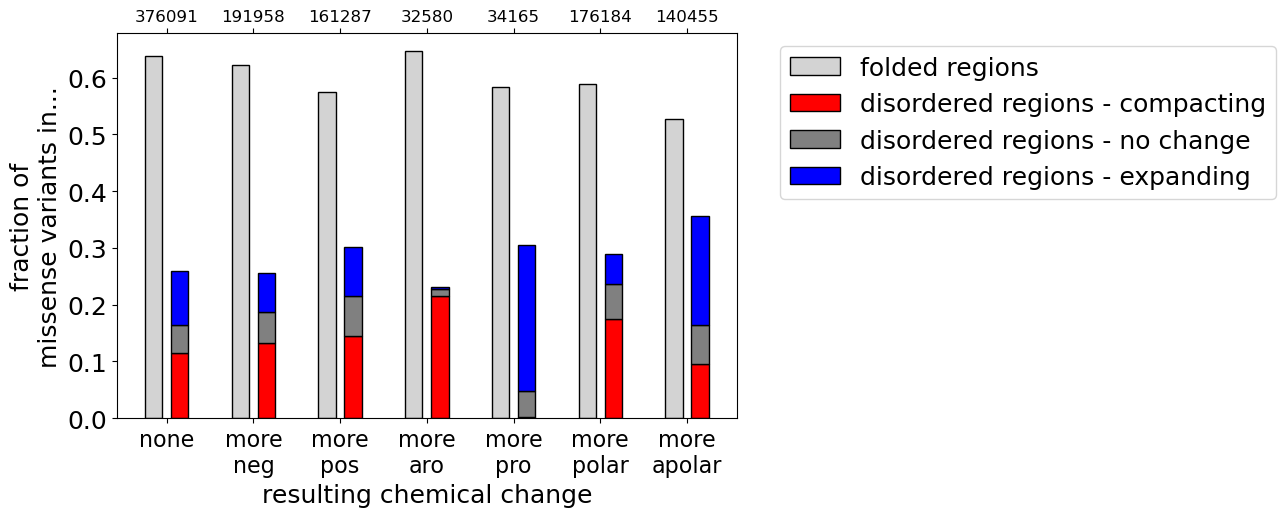

In [12]:
types = pd.DataFrame(index=data['changeType'].unique(),columns=['disordered','all','folded'])
changetypes=['none','pos>|>neg','neg>|>pos','>aro','>pro','>polar','>apolar']
fig,ax = plt.subplots(figsize=[8,5])
for i,changeType in enumerate(changetypes):
    sliced = data[data['changeType'].str.contains(changeType)]
    N_all = sliced.shape[0]
    N_folded = sliced[sliced['resDisordered']=='NO'].shape[0]
    N_disordered_compact = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']<0)&(sliced['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
    N_disordered_expand = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']>0)&(sliced['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
    N_disordered_nochange = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_pval_30_adj']<1.3)].shape[0]
#   print('all: %i, folded: %i, disordered: %i'%(N_all,N_folded,N_disordered_compact+N_disordered_nochange))
    #ax.bar(i-0.3,N_all,width=0.2)
    ax.text(i,0.7,str(N_all),ha='center',fontsize=12)
    ax.bar(i-0.15,N_folded/N_all,width=0.2,color='lightgrey',edgecolor='k',label='folded regions')
    ax.bar(i+0.15,N_disordered_compact/N_all,width=0.2,color='red',edgecolor='k',label='disordered regions - compacting')
    ax.bar(i+0.15,N_disordered_nochange/N_all,bottom=(N_disordered_compact)/N_all,width=0.2,color='grey',edgecolor='k',label='disordered regions - no change')
    ax.bar(i+0.15,N_disordered_expand/N_all,bottom=(N_disordered_nochange+N_disordered_compact)/N_all,width=0.2,color='blue',edgecolor='k',label='disordered regions - expanding')
    if i==0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(['none','more\nneg','more\npos','more\naro','more\npro','more\npolar','more\napolar'],fontsize=16)
ax.set_xlabel('resulting chemical change')
_=ax.set_ylabel('fraction of\nmissense variants in...')
ax.tick_params(axis='x', top=True, bottom=True, labelbottom=True)
plt.savefig('missense_changes.svg')

# GO onthology

## create GO analysis input files

The text files written here are used to feed into G:Profiler https://biit.cs.ut.ee/gprofiler/gost
all.txt is used as the background for enrichment.

In [13]:
Re_all_prots = data[(data['resDisordered']=='YES')]['upID'].unique()
Re_compact_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_delta_30']<-1.5)&(data['mut_vs_wt_Re_pval_35_adj']>1.3)]['upID'].unique()
Re_expand_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_delta_30']>1.5)&(data['mut_vs_wt_Re_pval_35_adj']>1.3)]['upID'].unique()

np.savetxt('compact.txt', Re_compact_prots, delimiter=',',fmt='%s') 
np.savetxt('expand.txt', Re_expand_prots, delimiter=',',fmt='%s') 
np.savetxt('all.txt', Re_all_prots, delimiter=',',fmt='%s')

## GO molecular function enrichement for Fig. 2D

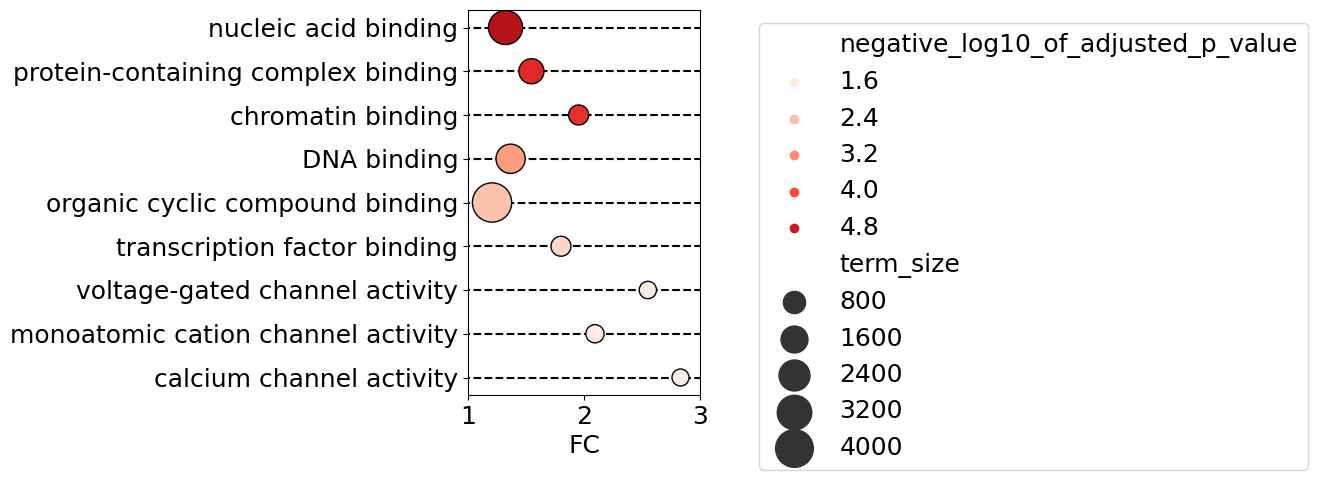

In [14]:
compact = pd.read_csv('./gProfiler_hsapiens_12-23-2024_compact.csv',
                      comment='#',)
compact['FC']=compact['intersection_size']/compact['query_size']/(compact['term_size']/compact['effective_domain_size'])
for source in ['GO:MF']:#,'GO:CC']:
    sliced = compact[(compact['source']==source)&(compact['term_size']>50)&(compact['FC']>1.1)&(compact['term_name'].str.len()<35)]
    fig,ax = plt.subplots(figsize=[3,5])
    ax.hlines(np.arange(len(sliced)),np.zeros(len(sliced)),np.ones(len(sliced))*4.5,
              color='k',linestyle='--',zorder=0)
    g = sns.scatterplot(x='FC',y='term_name',data=sliced,hue='negative_log10_of_adjusted_p_value',
               size='term_size',sizes=(150,800),palette='Reds',
               legend='brief',edgecolor='k',
               hue_norm=(1.3,6),ax=ax)
    g.legend(bbox_to_anchor=(1.2,1))
    ax.set_xlim(1,3)
    ax.set_ylabel('')

## GO cellular component enrichement for proteins experiencing missense-driven compaction

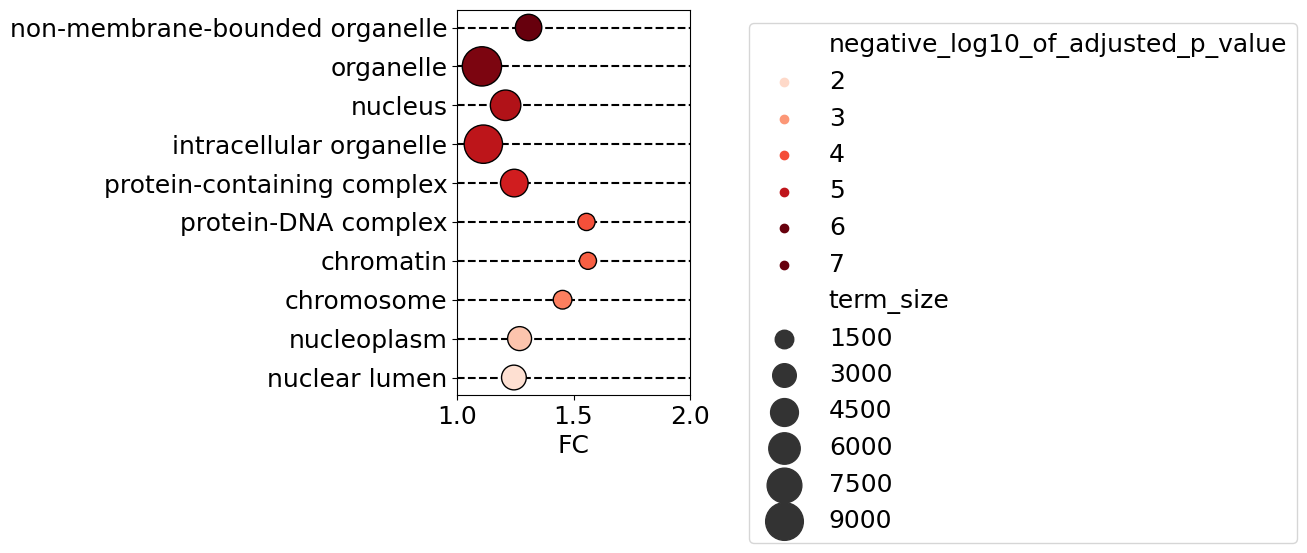

In [15]:
for source in ['GO:CC']:
    sliced = compact[(compact['source']==source)&(compact['term_size']>50)&(compact['FC']>1.1)&(compact['term_name'].str.len()<35)]
    fig,ax = plt.subplots(figsize=[3,5])
    ax.hlines(np.arange(len(sliced)),np.zeros(len(sliced)),np.ones(len(sliced))*4.5,
              color='k',linestyle='--',zorder=0)
    g = sns.scatterplot(x='FC',y='term_name',data=sliced,hue='negative_log10_of_adjusted_p_value',
               size='term_size',sizes=(150,800),palette='Reds',
               legend='brief',edgecolor='k',
               hue_norm=(1.3,6),ax=ax)
    g.legend(bbox_to_anchor=(1.2,1))
    ax.set_xlim(1,2)
    ax.set_ylabel('')

## GO biological process enrichement for proteins experiencing missense-driven compaction

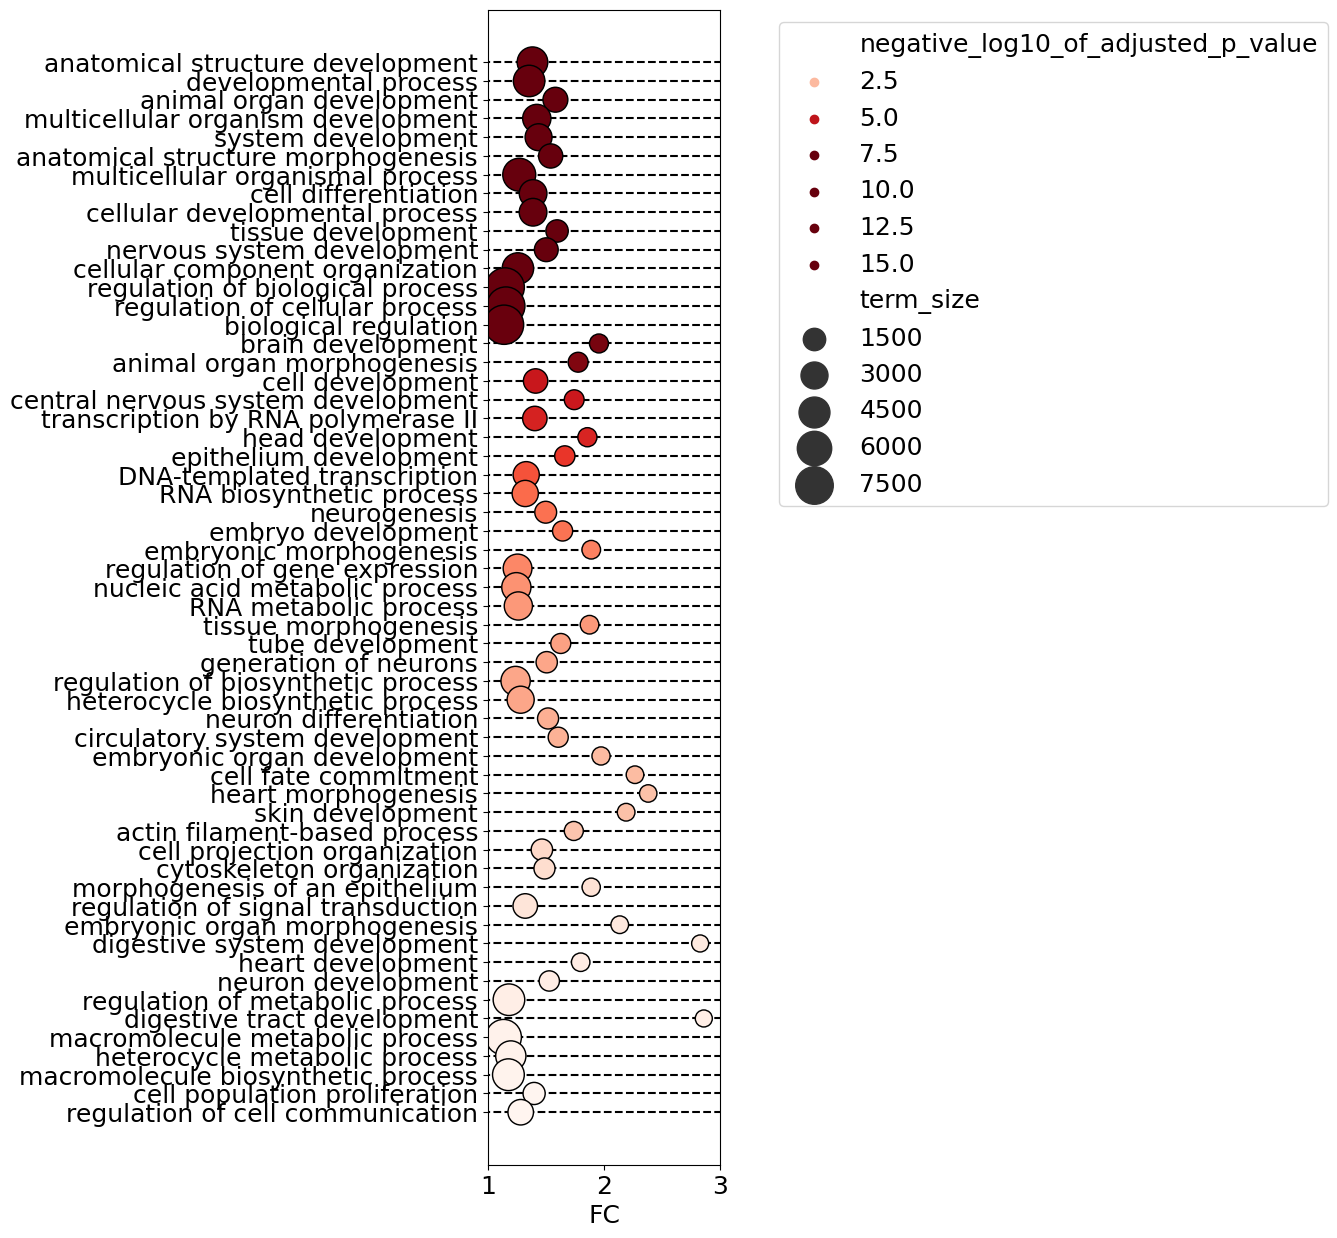

In [16]:
for source in ['GO:BP']:
    sliced = compact[(compact['source']==source)&(compact['term_size']>50)&(compact['FC']>1.1)&(compact['term_name'].str.len()<35)]
    fig,ax = plt.subplots(figsize=[3,15])
    ax.hlines(np.arange(len(sliced)),np.zeros(len(sliced)),np.ones(len(sliced))*4.5,
              color='k',linestyle='--',zorder=0)
    g = sns.scatterplot(x='FC',y='term_name',data=sliced,hue='negative_log10_of_adjusted_p_value',
               size='term_size',sizes=(150,800),palette='Reds',
               legend='brief',edgecolor='k',
               hue_norm=(1.3,6),ax=ax)
    g.legend(bbox_to_anchor=(1.2,1))
    ax.set_xlim(1,3)
    ax.set_ylabel('')